# Importing all the needed libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
customer_data = pd.read_csv('Mall_Customers.csv')

In [4]:
1 - np.tanh(- (0.6 ** 2) / 100)

1.0035999844480805

# Getting the dataset

In [5]:
customer_data['Gender'] = customer_data['Gender'].astype('category') 
customer_data.dtypes

CustomerID                   int64
Gender                    category
Age                          int64
Annual Income (k$)           int64
Spending Score (1-100)       int64
dtype: object

In [6]:
cat_columns = customer_data.select_dtypes(['category']).columns
customer_data[cat_columns] = customer_data[cat_columns].apply(lambda x: x.cat.codes)

For the sake of comparison later down the line, I will also take look at the FCM algorithm implemented in skfuzzy.

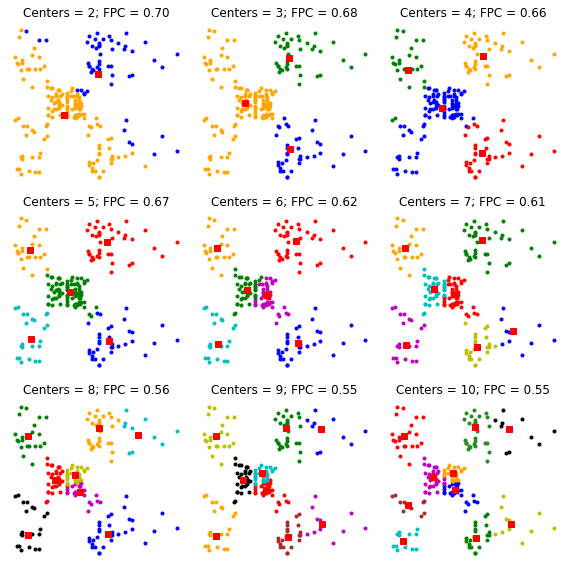

In [283]:
from __future__ import division, print_function
import skfuzzy as fuzz
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']
y_data = np.array(customer_data.iloc[:, 4].values)
x_data = np.array(customer_data.iloc[:, 3].values)
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
alldata = np.vstack((x_data, y_data))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(x_data[cluster_membership == j],
                y_data[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()

# Helper functions

The functions below serve the purpose of making the main algorithm easier to follow and more generic at the same time.
Every one of the following functions serve the purpose of updating the memberships, the centres or the cost functions.

In [223]:
def fcm_memberships(y, euc_dist):
    temp = euc_dist ** (2 / (m - 1))
    denominator = temp.reshape((y.shape[0], 1, -1)).repeat(temp.shape[-1], axis=1)
    denominator = temp[:, :, np.newaxis] / denominator
    u = 1 / denominator.sum(2)
    return u

def t2fcm_memberships(u):
    a = u - ((1 - u) / 2)
    return a

def hyper_tangent_kernel(euc_dist, sigma):
    return 1 - np.tanh(- (euc_dist ** 2) / (sigma ** 2))

def kt2fcm_memberships(y, euc_dist, sigma):
    nominator = (1 / np.tanh(- (euc_dist ** 2) / (sigma ** 2))) ** (1 / (m - 1))
    denominator = nominator.copy()
    u = nominator.T / denominator.sum(1)
    return u.T

def kt2fcm_centres(a, y, euc_dist, sigma, v):
    am = a ** m
    kern = hyper_tangent_kernel(euc_dist, sigma)
    kern_2 = 2 + kern
    for i in range(a.shape[1]):
        sum_nom = 0
        sum_denom = 0
        for k in range(a.shape[0]):
            sum_nom += am[k, i] * kern[k, i] * kern_2[k, i] * y[k]
            sum_denom += am[k, i] * kern[k, i] * kern_2[k, i]
        v[i] = sum_nom / sum_denom
    return v

def kt2fcm_cost(a, euc_dist):
    am = a ** m
    kern = hyper_tangent_kernel(euc_dist, sigma)
    j_m = 0
    for i in range(a.shape[1]):
        j_m_k = 0
        for k in range(a.shape[0]):
            j_m_k += am[k, i] * (1 - kern[k, i])
        j_m += j_m_k
    j_m = 2 * j_m
    return j_m

def fcm_cost(um, euc_dist):
    j_m = (um * euc_dist ** 2).sum()
    return j_m

def normalize_values(u):
    u = u / np.tile(u.sum(axis=1)[np.newaxis].T, c)
    u = np.fmax(u, np.finfo(np.float64).eps)
    return u
    
def update_memberships(y, u, a, euc_dist=0, method='FCM'):
    u = fcm_memberships(y, euc_dist)
    
    if method == 'FCM':
        u = np.fmax(u, np.finfo(np.float64).eps)
        return u, a
    
    if method == 'T2FCM':
        a = t2fcm_memberships(u)
        a = np.fmax(a, np.finfo(np.float64).eps)
        return u, a


def update_centres(um, y, method='FCM'):
    if method == 'FCM' or method == 'T2FCM':
        return (y.T @ um / np.sum(um, axis=0)).T

# The main algorithm

The main algorithm for fuzzy clustering, generalized for the sake of making it easier to understand.

In [233]:
# FCM algorithm
y = np.array(customer_data.iloc[:, [3, 4]].values)
#y[:, 0] *= 1000
possible_c = range(2,9)
m = 2
max_iter = 1000
error = 0.005
method = 'T2FCM'

for c in possible_c:
    np.random.seed(seed=None)
    n = y.shape[0]
    #Initialize the membership values
    u = np.random.randn(n, c)
    a = [] # even if not used, it must be initialised
    if method == 'T2FCM':
        a = t2fcm_memberships(u)
        a = normalize_values(a)
    else:
        u = normalize_values(u)
    print(f'Algorithm with: max_iter: {max_iter}, error: {error}, m: {m}, no. cluster: {c}\n')
    end_iter = 0
    j_m = 0
    fpc = 0
    v_final = None
    
    # The actual algorithm starts here
    for i in range(max_iter):
        # Centres
        if method == 'FCM':
            um = u ** m
            u_old = u.copy()
            v = update_centres(um, y, method)
        elif method == 'T2FCM':
            am = a ** m
            a_old = a.copy()
            v = update_centres(am, y, method)
        
        # calculating the distance between the points and clusters
        euc_dist = cdist(y, v, metric='euclidean') #  np.sqrt(np.einsum("ijk->ij", (y[:, None, :] - v) ** 2))
        euc_dist = np.fmax(euc_dist, np.finfo(np.float64).eps)
        
        # cost function
        if method == 'FCM':
            j_m = fcm_cost(um, euc_dist)
        elif method == 'T2FCM':
            j_m = fcm_cost(am, euc_dist)
        
        # New memberships
        u, a = update_memberships(y, u, a, euc_dist, method)
        
        end_iter = i
        v_final = np.copy(v)
        
        # final condition
        if method == 'FCM' and np.linalg.norm(u - u_old) < error:
            break
        elif method == 'T2FCM' and np.linalg.norm(a - a_old) < error:
            break
    
    ## fuzzy c partition
    n = u.shape[0]
    if method == 'FCM':
        fpc = np.trace(u.T @ u) / n
    else:
        fpc = np.trace(a.T @ a) / n
    
    print(f'Centres are:\n{v_final}\n')
    print(f'Algorithm ended at iteration {end_iter} with cost {j_m} and fuzzy c partition {fpc}\n')

Algorithm with: max_iter: 1000, error: 0.005, m: 2, no. cluster: 2

Centres are:
[[85.49183712 82.15009298]
 [51.30755644 42.05264103]]

Algorithm ended at iteration 18 with cost 66139.45061595371 and fuzzy c partition 0.6073920488333248

Algorithm with: max_iter: 1000, error: 0.005, m: 2, no. cluster: 3

Centres are:
[[47.51262934 50.30972475]
 [83.83197427 83.98308726]
 [85.24754581 14.99904891]]

Algorithm ended at iteration 12 with cost 27541.220122413077 and fuzzy c partition 0.5526239073782768

Algorithm with: max_iter: 1000, error: 0.005, m: 2, no. cluster: 4

Centres are:
[[83.66656579 84.73651544]
 [84.70673395 14.11595857]
 [24.07615763 79.89526906]
 [54.2091917  48.89635559]]

Algorithm ended at iteration 17 with cost 14954.366186947676 and fuzzy c partition 0.5393774096980168

Algorithm with: max_iter: 1000, error: 0.005, m: 2, no. cluster: 5

Centres are:
[[129.02399884  21.29497324]
 [ 55.16008365  50.15008403]
 [ 24.29944882  80.28679804]
 [ 98.77837769  22.58614157]
 [ 

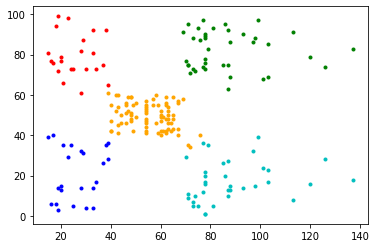

In [287]:
"""
fcm 2 clusters
[[50.9442013,  58.35794113],
 [77.19506411, 32.51722748]]

fcm 5 clusters
[[27.05715981, 18.60008872],
 [56.26581802, 49.57635777],
 [84.41308469, 82.77480565],
 [26.46395779, 77.85618678],
 [86.13140544, 16.74134002]]
"""
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']
y = np.array(customer_data.iloc[:, [3, 4]].values)
y_data = np.array(customer_data.iloc[:, 4].values)
x_data = np.array(customer_data.iloc[:, 3].values)
euc_dist = cdist(y, v, metric='euclidean') #  np.sqrt(np.einsum("ijk->ij", (y[:, None, :] - v) ** 2))
euc_dist = np.fmax(euc_dist, np.finfo(np.float64).eps)
v = np.array([[27.05715981, 18.60008872],
 [56.26581802, 49.57635777],
 [84.41308469, 82.77480565],
 [26.46395779, 77.85618678],
 [86.13140544, 16.74134002]])
u = []
a = []
u, a = update_memberships(y, u, a, euc_dist, 'FCM')
cluster_membership = np.argmax(u, axis=1)
cluster_membership
for j in range(v.shape[0]):
    plt.plot(x_data[cluster_membership == j], y_data[cluster_membership == j], '.', color=colors[j])
plt.show()

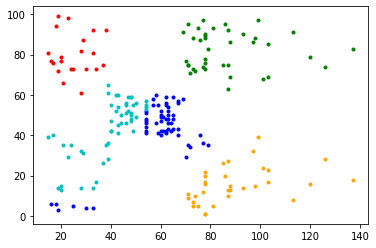

In [291]:
"""
t2fcm 2 clusters
[[85.4893897,  82.15338118],
 [51.31395068, 42.05015175]]
 
t2fcm 5 clusters
[[62.36251004, 47.44536002],
 [83.32420415, 12.97132183],
 [83.12384879, 86.56905272],
 [23.33179551, 80.29037045],
 [44.54113685, 49.86403193]]
"""
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']
y = np.array(customer_data.iloc[:, [3, 4]].values)
y_data = np.array(customer_data.iloc[:, 4].values)
x_data = np.array(customer_data.iloc[:, 3].values)
euc_dist = cdist(y, v, metric='euclidean') #  np.sqrt(np.einsum("ijk->ij", (y[:, None, :] - v) ** 2))
euc_dist = np.fmax(euc_dist, np.finfo(np.float64).eps)
v = np.array([[62.36251004, 47.44536002],
 [83.32420415, 12.97132183],
 [83.12384879, 86.56905272],
 [23.33179551, 80.29037045],
 [44.54113685, 49.86403193]])
u = []
a = []
u, a = update_memberships(y, u, a, euc_dist, 'T2FCM')
cluster_membership = np.argmax(a, axis=1)
cluster_membership
for j in range(v.shape[0]):
    plt.plot(x_data[cluster_membership == j], y_data[cluster_membership == j], '.', color=colors[j])
plt.show()

In [230]:
# FCM algorithm
y = np.array(customer_data.iloc[:, [3, 4]].values)
#y[:, 0] *= 1000
possible_c = range(2,9)
m = 2
max_iter = 1000
error = 0.005
sigma = 100

for c in possible_c:
    a = []
    np.random.seed(seed=None)
    n = y.shape[1]
    #Initialize the membership values
    v = np.random.uniform(low=0, high=140, size=(c,n))
    euc_dist = cdist(y, v, metric='euclidean') #  np.sqrt(np.einsum("ijk->ij", (y[:, None, :] - v) ** 2))
    euc_dist = np.fmax(euc_dist, np.finfo(np.float64).eps)
    a = kt2fcm_memberships(y, euc_dist, sigma) # even if not used, it must be initialised
    a = np.fmax(a, np.finfo(np.float64).eps)
    print(f'Algorithm with: max_iter: {max_iter}, error: {error}, m: {m}, no. cluster: {c} and sigma: {sigma}\n')
    end_iter = 0
    j_m = 0
    fpc = 0
    v_final = None
    for i in range(max_iter):
        a_old = a.copy()
        v = kt2fcm_centres(a, y, euc_dist, sigma, v)
        euc_dist = cdist(y, v, metric='euclidean') #  np.sqrt(np.einsum("ijk->ij", (y[:, None, :] - v) ** 2))
        euc_dist = np.fmax(euc_dist, np.finfo(np.float64).eps)
        a = kt2fcm_memberships(y, euc_dist, sigma)
        a = np.fmax(a, np.finfo(np.float64).eps)
        #print(a)
        v_final = v.copy()
        j_m = kt2fcm_cost(a, euc_dist)
        end_iter = i
        if np.linalg.norm(a - a_old) < error:
            break
    
    n = a.shape[0]
    fpc = np.trace(a.T @ a) / n
    print(f'Centres are:\n{v_final}\n')
    print(f'Algorithm ended at iteration {end_iter} with cost {j_m} and fuzzy c partition {fpc}\n')

Algorithm with: max_iter: 1000, error: 0.005, m: 2, no. cluster: 2 and sigma: 100

Centres are:
[[75.46265046 39.11712526]
 [50.65517111 56.86330314]]

Algorithm ended at iteration 101 with cost -24.657699756560348 and fuzzy c partition 0.6488420440266021

Algorithm with: max_iter: 1000, error: 0.005, m: 2, no. cluster: 3 and sigma: 100

Centres are:
[[77.69346563 21.7697702 ]
 [77.52215138 78.02371782]
 [45.78948699 50.26049069]]

Algorithm ended at iteration 16 with cost -13.321326122264862 and fuzzy c partition 0.6544981261487919

Algorithm with: max_iter: 1000, error: 0.005, m: 2, no. cluster: 4 and sigma: 100

Centres are:
[[29.68266163 67.22096825]
 [81.79305722 17.18324105]
 [82.81671073 80.06742316]
 [53.76206224 46.75275595]]

Algorithm ended at iteration 42 with cost -8.665971302388783 and fuzzy c partition 0.6351428507050088

Algorithm with: max_iter: 1000, error: 0.005, m: 2, no. cluster: 5 and sigma: 100

Centres are:
[[29.01429916 20.69494245]
 [86.14680691 17.34242101]
 

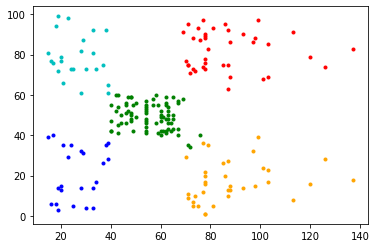

In [295]:
"""
kt2fcm 2 clusters
[[75.46265046, 39.11712526],
 [50.65517111, 56.86330314]]
 
kt2fcm 5 clusters
[[29.01429916, 20.69494245],
 [86.14680691, 17.34242101],
 [56.84130693, 49.55403297],
 [84.35416853, 82.21372389],
 [28.11279878, 76.84086138]]
"""
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']
y = np.array(customer_data.iloc[:, [3, 4]].values)
y_data = np.array(customer_data.iloc[:, 4].values)
x_data = np.array(customer_data.iloc[:, 3].values)
euc_dist = cdist(y, v, metric='euclidean') #  np.sqrt(np.einsum("ijk->ij", (y[:, None, :] - v) ** 2))
euc_dist = np.fmax(euc_dist, np.finfo(np.float64).eps)
v = np.array([[29.01429916, 20.69494245],
 [86.14680691, 17.34242101],
 [56.84130693, 49.55403297],
 [84.35416853, 82.21372389],
 [28.11279878, 76.84086138]])
sigma = 100
a = []
a = kt2fcm_memberships(y, euc_dist, sigma)
cluster_membership = np.argmax(a, axis=1)
cluster_membership
for j in range(v.shape[0]):
    plt.plot(x_data[cluster_membership == j], y_data[cluster_membership == j], '.', color=colors[j])
plt.show()

# Further data explanation, for those interested

Below you can see how the data points are arranged and how each feature looks

In [15]:
customer_data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6
3,4,0,23,16,77
4,5,0,31,17,40


In [8]:
customer_data.shape

(200, 5)

In [9]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   CustomerID              200 non-null    int64
 1   Gender                  200 non-null    int8 
 2   Age                     200 non-null    int64
 3   Annual Income (k$)      200 non-null    int64
 4   Spending Score (1-100)  200 non-null    int64
dtypes: int64(4), int8(1)
memory usage: 6.6 KB


In [10]:
customer_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

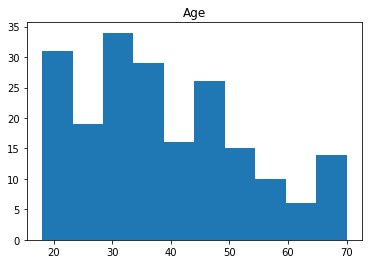

In [11]:
customer_data.hist(column="Age", grid=False);

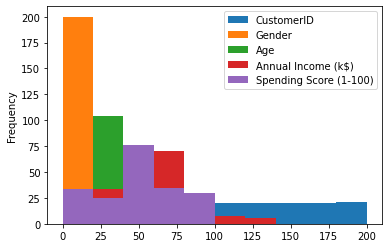

In [12]:
customer_data.plot(kind='hist');

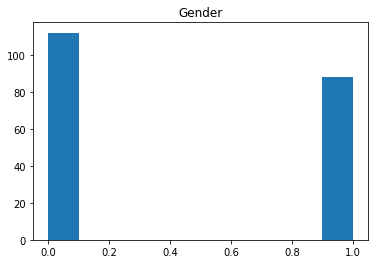

In [13]:
customer_data.hist(column="Gender", grid=False);

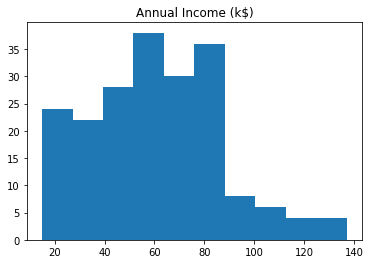

In [14]:
customer_data.hist(column="Annual Income (k$)", grid=False);

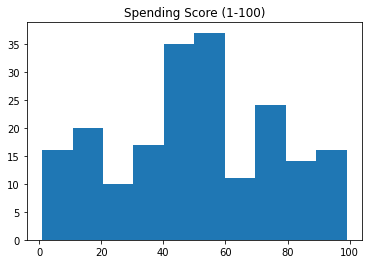

In [15]:
customer_data.hist(column="Spending Score (1-100)", grid=False);

In [16]:
X = customer_data.iloc[:,[3,4]].values
#X

<AxesSubplot:xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

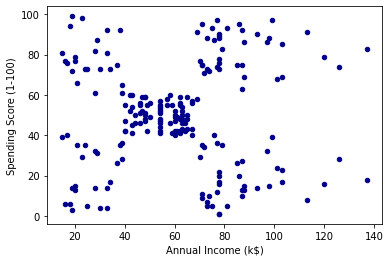

In [17]:
customer_data.plot.scatter(x='Annual Income (k$)',
                          y='Spending Score (1-100)',
                          c='DarkBlue')

<AxesSubplot:xlabel='Age', ylabel='Spending Score (1-100)'>

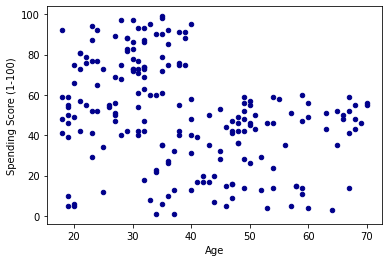

In [18]:
customer_data.plot.scatter(x='Age',
                          y='Spending Score (1-100)',
                          c='DarkBlue')

<AxesSubplot:xlabel='Age', ylabel='Annual Income (k$)'>

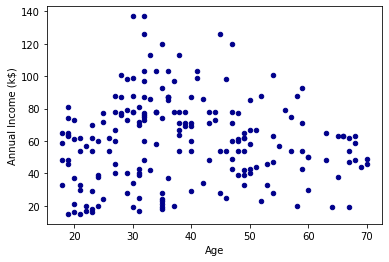

In [19]:
customer_data.plot.scatter(x='Age',
                          y='Annual Income (k$)',
                          c='DarkBlue')

<AxesSubplot:xlabel='Gender', ylabel='Annual Income (k$)'>

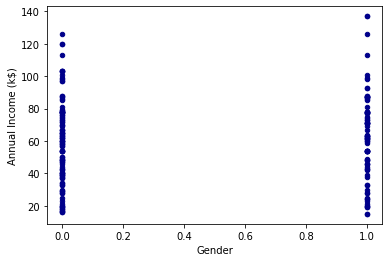

In [20]:
customer_data.plot.scatter(x='Gender',
                          y='Annual Income (k$)',
                          c='DarkBlue')